# COVID-19: Deep-dive EDA for INDIA
### This Kernel is created to provide a daily in-depth view into the current Covid-19 situation in India. 
##### This kernel is inspired by a lot of different amazing kernels by folks on kaggle. References below.
![](http://)![Covid19 Trend in India](https://miro.medium.com/max/1400/1*TOnqCoCPCgoA1eimzdL0aw.jpeg)

##### We will be using Plotly throughout this kernel to make sure that the visualizations are interactive and nicely formatted. 

## Table of contents
1. [Load and Prepare Data](#load-data)
2. [Nationwide Cases/Deaths Trend over time](#nationwide-trend)
3. [Deep-dive across the states](#deep-dive)
4. [Growth rate across the different states](#growth-rates)
5. [Modeling convergance of the infections for India](#sigmoid-model)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_white"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)
from datetime import datetime, timedelta

## 1. Load and Prepare Data <a id="load-data"></a> 


### The data used in this kernel is provided by [Covid19India.Org](https://api.covid19india.org/csv/). This is a volunteer-driven, crowdsourced database for COVID-19 stats & patient tracing in India. The data is updated in a new real-time situation and is provided in [CSV/JSON](https://api.covid19india.org/) format.<br/>
**Personal note**: I am sure it takes a tremendous amount of effort to collate and maintain this form of data. Thanks to the [Covid19India.Org](https://telegra.ph/CoVID-19--India-Ops-03-24) team. Follow them on [Telegram](https://t.me/covid19indiaops), for more information.

#### Let's get the Death and Recovered counts for the patients before 26th April 2020, and then merge them into the main dataset with confirmed cases

In [ ]:
death_and_recovered_url = "https://api.covid19india.org/csv/latest/death_and_recovered.csv"
dar_df = pd.read_csv(death_and_recovered_url)
dar_df["Date"] = pd.to_datetime(dar_df["Date"], format = "%d/%m/%Y")

In [ ]:
dar_statewise_daily_stats = dar_df.groupby(["State","Date","Patient_Status"], as_index=False).agg({"Sl_No":"count"}).rename({"Sl_No":"DailyCases"}, axis=1)
dar_statewise_daily_stats = dar_statewise_daily_stats.rename({"Patient_Status":"Current Status"}, axis=1)

In [ ]:
raw_data_url = "https://api.covid19india.org/csv/latest/raw_data.csv"
raw_data = pd.read_csv(raw_data_url)
raw_data["Date"] = pd.to_datetime(raw_data["Date Announced"], format = "%d/%m/%Y")
raw_data["State"] = raw_data["Detected State"]
hosp_statewise_daily_stats1 = raw_data.groupby(["State","Date","Current Status"], as_index=False).agg({"Patient Number":"count"}).rename({"Patient Number":"DailyCases"}, axis=1)
hosp_statewise_daily_stats1["Current Status"] = "Hospitalized"

In [ ]:
statewise_daily_stats1 = hosp_statewise_daily_stats1.append(dar_statewise_daily_stats)

#### Now, let's merge the data till 9th May in the datset

In [ ]:
raw_data3_url = "https://api.covid19india.org/csv/latest/raw_data3.csv"
raw_data3 = pd.read_csv(raw_data3_url)
raw_data3["Date"] = pd.to_datetime(raw_data3["Date Announced"], format = "%d/%m/%Y")
raw_data3["State"] = raw_data3["Detected State"]
statewise_daily_stats3 = raw_data3.groupby(["State","Date","Current Status"], as_index=False).agg({"Num Cases":"sum"}).rename({"Num Cases":"DailyCases"}, axis=1)

In [ ]:
statewise_daily_stats = statewise_daily_stats1.append(statewise_daily_stats3)
statewise_daily_stats = statewise_daily_stats[statewise_daily_stats["Current Status"].isin(["Hospitalized","Recovered","Deceased"])]

#### Merging the final datset after 9th May into the main dataset

In [ ]:
raw_data4_url = "https://api.covid19india.org/csv/latest/raw_data4.csv"
raw_data4 = pd.read_csv(raw_data4_url)
raw_data4["Date"] = pd.to_datetime(raw_data4["Date Announced"], format = "%d/%m/%Y")
raw_data4["State"] = raw_data4["Detected State"]
statewise_daily_stats4 = raw_data4.groupby(["State","Date","Current Status"], as_index=False).agg({"Num Cases":"sum"}).rename({"Num Cases":"DailyCases"}, axis=1)

In [ ]:
statewise_daily_stats = statewise_daily_stats.append(statewise_daily_stats4)
statewise_daily_stats = statewise_daily_stats[statewise_daily_stats["Current Status"].isin(["Hospitalized","Recovered","Deceased"])]

## 2. Nationwide Daily Cases Trend over time  <a id="nationwide-trend"></a>

### Let's start by looking at the daily number of cases/deaths trend for the entire nation. 
#### The daily number of cases and deaths seem to be ever-increasing at an exponential rate, even with a lockdown in place

In [ ]:
last_date = statewise_daily_stats["Date"].max().strftime("%d %b %Y")
fig = px.line(statewise_daily_stats.groupby(["Date","Current Status"], as_index=False).agg({"DailyCases":"sum"}), x="Date", y="DailyCases", color='Current Status', 
              title=f"Nationwide Confirmed/Death Cases Over Time as on {last_date}")
fig.show()

#### However, One of the most important metric for any country in this time of crisis, is the Mortality Rate of the country due to COVID-19. Mortality rate is defined as the percentage of infected population that is deceased due to the infections. 
#### **Thankfully**, it is ~2% in India and is following a downward trend. A 10-day moving average line is overlayed to give clearer idea of the trend being followed by the Mortality Rate

In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
#statewise_daily_stats_pivot.head()
national_mortality_rate = statewise_daily_stats_pivot.groupby("Date").agg({"Deceased":"sum", "Hospitalized":"sum", "Recovered":"sum"})
national_mortality_rate = national_mortality_rate.reset_index()
national_mortality_rate["MortalityRate"] = (national_mortality_rate["Deceased"]/national_mortality_rate["Hospitalized"])*100
national_mortality_rate["MortalityRateMA"] = national_mortality_rate["MortalityRate"].rolling(10).mean()

fig = px.line(national_mortality_rate, x="Date", y="MortalityRate", 
              title="Nationwide Mortality Rate Over Time")
fig.add_scatter(x=national_mortality_rate['Date'], y=national_mortality_rate['MortalityRateMA'], mode='lines')
fig.show()

The Mortality rate seems to be constant in India at around **2%**, however, it seems like it is declining over time. 

## 3. Deep-dive into the situation across the states <a id="deep-dive"></a>

#### Let's start the deep-dive by looking at the distribution of the number of cases across India into the different states using a [TreeMap](https://datavizcatalogue.com/methods/treemap.html). This will help us in understanding the contribution of the different states to total number of cases/deaths.
#### Also, we have pyplot for all of these visualizations to make them interactive. Hence, we can know the exact number of cases in any state just by hovering over the state and 

In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
statewise_daily_stats_pivot = statewise_daily_stats_pivot.rename({"Hospitalized":"Total Cases"}, axis=1)
statewise_daily_stats_pivot["Active"] = statewise_daily_stats_pivot["Total Cases"] - (statewise_daily_stats_pivot["Deceased"] + statewise_daily_stats_pivot["Recovered"])
statewise_stats = pd.melt(statewise_daily_stats_pivot, id_vars=['State','Date'], value_vars=['Deceased','Active','Recovered'],var_name='Current Status', value_name='DailyCases')
statewise_stats = statewise_stats.groupby(["State","Current Status"], as_index=False).agg({"DailyCases":"sum"})
fig = px.treemap(statewise_stats.query("DailyCases > 0"), path=['State', 'Current Status'], values='DailyCases', color='State', title=f'Cases Distribution across states as on {last_date}')
fig.show()

#### Here, Maharashtra, Delhi, Gujarat and Tamil Nadu are leading the number of cases on a national level. At a superficial level this tells us the spread of infection, however what's more important is the way that the states are responsing to this high number of cases. We can look at the Mortality Rate to understand the situation in these states.
#### Even though a state is having high number of cases, it is not necessary that the Mortality rate is also as high.

In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
statewise_mortality_rate = statewise_daily_stats_pivot.groupby("State").agg({"Deceased":"sum", "Hospitalized":"sum", "Recovered":"sum"})
statewise_mortality_rate["Total Cases"] = statewise_mortality_rate.sum(axis=1)
statewise_mortality_rate = statewise_mortality_rate.reset_index()
statewise_mortality_rate["MortalityRate"] = (statewise_mortality_rate["Deceased"]/statewise_mortality_rate["Total Cases"])*100

fig = px.bar(statewise_mortality_rate.sort_values("MortalityRate", ascending=False),
             x='State', y='MortalityRate', barmode='group',
             title=f'Mortality Rate across the states as on {last_date}',height=600)
fig.show()

#### This is very different from what we expected, **West Bengal** has highest Mortality Rate of **6.28%**, followed by Gujarat and Madhya Pradesh. 
#### Now, let's look at the top 15 states that are contributing highest to the number of cases across India.

In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
statewise_daily_stats_pivot["Total Cases"] = statewise_daily_stats_pivot["Hospitalized"]
TOP_N = 10

top_states = statewise_daily_stats_pivot.groupby("State", as_index=False).agg({"Total Cases":"sum"}).sort_values("Total Cases", ascending=False).State.reset_index(drop=True)[:TOP_N]
top_states_df = statewise_daily_stats[statewise_daily_stats["State"].isin(top_states)]

fig = px.line(top_states_df[top_states_df["Current Status"] == "Hospitalized"], x="Date", y="DailyCases",color="State", 
              title=f"Statewise Total Cases Over Time as on {last_date}")
#fig.add_scatter(x=national_mortality_rate['Date'], y=national_mortality_rate['MortalityRateMA'], mode='lines')
fig.show()


In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
TOP_N = 10

top_states = statewise_daily_stats_pivot.groupby("State", as_index=False).agg({"Deceased":"sum"}).sort_values("Deceased", ascending=False).State.reset_index(drop=True)[:TOP_N]
top_states_df = statewise_daily_stats[statewise_daily_stats["State"].isin(top_states)]

fig = px.line(top_states_df[top_states_df["Current Status"] == "Deceased"], x="Date", y="DailyCases",color="State", 
              title=f"Statewise Fatalities Over Time as on {last_date}")
#fig.add_scatter(x=national_mortality_rate['Date'], y=national_mortality_rate['MortalityRateMA'], mode='lines')
fig.show()

#### The results are as expected in the above charts. Maharashtra and Gujarat are the highest contributors to the overall deaths. However, that peak on May 3 in West Bengal is probably the reason for the overall high mortality rate of West Bengal.

## Growth rate across the different states <a id="growth-rates"></a>

#### Let's look at the rate at which these states are experiencing new cases. We will be taking starting point as the day on which the state touched a total of 10 cases. 
#### We will be using Log scale to do the comparison and see the rate of which the cases are doubling in the states.

In [ ]:
TOP_N_STATES = 10
N_START_FATALITIES= 5

statewise_daily_stats_pivot["Total Cases"] = statewise_daily_stats_pivot["Hospitalized"] + statewise_daily_stats_pivot["Deceased"] + statewise_daily_stats_pivot["Recovered"]
statewise_daily_stats_pivot["CumulativeTotalCases"] = statewise_daily_stats_pivot.groupby("State")["Total Cases"].cumsum()

top_states = statewise_daily_stats_pivot.groupby("State").agg({"Total Cases":"sum"}).sort_values('Total Cases', ascending=False).iloc[:TOP_N_STATES].index.values.tolist()
statewise_daily_cases_cum = statewise_daily_stats_pivot[statewise_daily_stats_pivot["State"].isin(top_states)]
statewise_daily_cases_cum = statewise_daily_cases_cum[["State","Date","Total Cases", "CumulativeTotalCases"]]
statewise_daily_cases_cum = statewise_daily_cases_cum.sort_values(["State", "Date"])
statewise_daily_cases_cum = statewise_daily_cases_cum.query("CumulativeTotalCases > 10")
statewise_daily_cases_cum["DaysSince10"] = statewise_daily_cases_cum.groupby("State",as_index=False).cumcount()+1
statewise_daily_cases_cum["LogCumulativeTotalCases"] = np.log10(statewise_daily_cases_cum["CumulativeTotalCases"])

fig = px.line(statewise_daily_cases_cum, x='DaysSince10', y='LogCumulativeTotalCases', color='State', title=f'Total Cases (Log Scale) by State since 10 cases as on {last_date}')
fig.add_trace(go.Scatter(x=[0, 7*10], y=[1, np.log10(10*(2**10))], name='Double by 7 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 14*5], y=[1, np.log10(10*(2**5))], name='Double by 14 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 21*3.34], y=[1, np.log10(10*(2**3.34))], name='Double by 21 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.update_layout( xaxis_title='Days since 10 cases recorded', yaxis_title='Logarithm of Total Cases')
fig.show()


#### The Grey lines above indicate the path to follow to double cases every 1/2/3 weeks. Some of the states like Maharashtra are now close to the 3 week line in terms of slope. However, come of the states are still somewhere around doubling every 2 weeks.

In [ ]:
TOP_N_STATES = 10
N_START_FATALITIES= 5

statewise_daily_stats_pivot["CumulativeDeceased"] = statewise_daily_stats_pivot.groupby("State")["Deceased"].cumsum()
top_states = statewise_daily_stats_pivot.groupby("State").agg({"Deceased":"sum"}).sort_values('Deceased', ascending=False).iloc[:TOP_N_STATES].index.values.tolist()
statewise_daily_fatalities = statewise_daily_stats_pivot[statewise_daily_stats_pivot["State"].isin(top_states)]
statewise_daily_fatalities = statewise_daily_fatalities[["State","Date","Deceased", "CumulativeDeceased"]]
statewise_daily_fatalities = statewise_daily_fatalities.sort_values(["State", "Date"])
statewise_daily_fatalities = statewise_daily_fatalities.query("CumulativeDeceased > 10")
statewise_daily_fatalities["DaysSince10"] = statewise_daily_fatalities.groupby("State",as_index=False).cumcount()+1
statewise_daily_fatalities["LogCumulativeDeceased"] = np.log10(statewise_daily_fatalities["CumulativeDeceased"])

fig = px.line(statewise_daily_fatalities, x='DaysSince10', y='LogCumulativeDeceased', color='State', title=f'Fatalities by State since 10 deaths')
fig.add_trace(go.Scatter(x=[0, 7*6], y=[1, np.log10(10*(2**6))], name='Double by 7 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 14*3], y=[1, np.log10(10*(2**3))], name='Double by 14 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.add_trace(go.Scatter(x=[0, 21*2], y=[1, np.log10(10*(2**2))], name='Double by 21 days', line=dict(dash='dash', color=('rgb(200, 200, 200)'))))
fig.show()

#### Doing a similar analysis on the Fatalities over time, it's a relief to see that the cases of deaths are growing at a pace even slower than 21 days, for most of the states. But, for some of the states like Delhi, unfortunately the cases of deaths have recently started increasing at a pace of double every 7 days.

#### Since we're using Plotly, we can take advantage of the animation feature, and look at graphs evolving over days. I am still trying to create one for India and show the growth as an animation across states, however, Plotly doesn't support a state-level graph for India. Below, we're going to look at the growth across time axis and Mortality Rate.

In [ ]:
statewise_daily_stats_pivot = pd.pivot_table(statewise_daily_stats, index = ["State","Date"], columns = "Current Status", values="DailyCases").reset_index().fillna(0)
statewise_daily_stats_pivot["Total Cases"] = statewise_daily_stats_pivot["Hospitalized"] + statewise_daily_stats_pivot["Deceased"] + statewise_daily_stats_pivot["Recovered"]

max_date = statewise_daily_stats_pivot["Date"].max()
min_date = statewise_daily_stats_pivot["Date"].min()
    
date_range = int((max_date - min_date).days)
reqd_date_values = pd.DataFrame([min_date + timedelta(days=i) for i in range(date_range+1)], columns = ["Date"])
reqd_date_values["key"] = "0"

reqd_state_values = pd.DataFrame(statewise_daily_stats_pivot.State.unique(), columns = ["State"])
reqd_state_values["key"] = "0"
reqd_values = pd.merge(reqd_date_values, reqd_state_values, how="outer")
#reqd_values
statewise_daily_stats_pivot = statewise_daily_stats_pivot.merge(reqd_values, on=["State","Date"], how="right").fillna(0)
statewise_daily_stats_pivot = statewise_daily_stats_pivot.sort_values(["State","Date"])

In [ ]:
statewise_daily_stats_pivot["CumulativeDeceased"] = statewise_daily_stats_pivot.groupby("State")["Deceased"].cumsum()
statewise_daily_stats_pivot["CumulativeCases"] = statewise_daily_stats_pivot.groupby("State")["Total Cases"].cumsum()
statewise_daily_stats_pivot["CumulativeMR"] = statewise_daily_stats_pivot["CumulativeDeceased"]*100/statewise_daily_stats_pivot["CumulativeCases"]
statewise_daily_stats_pivot["StrDate"] = statewise_daily_stats_pivot["Date"].apply(lambda x:x.strftime("%d-%m"))
statewise_daily_stats_pivot.sort_values("Date", inplace=True)

In [ ]:
fig = px.scatter(statewise_daily_stats_pivot.query("Date > '2020-03-01'"), x="Date", y="CumulativeMR", animation_frame = "StrDate", animation_group="State",
           size="CumulativeCases", color="State", hover_name="State",
           log_x=False, size_max=100, range_x=["2020-03-01",statewise_daily_stats_pivot["Date"].max()], range_y=[0,10])
fig.update_layout(
        title=f"Growth of Covid-19 over a period of time as of {last_date}", xaxis_title='Date', yaxis_title='Mortality Rate')
fig.show()

## Modeling convergance of the infections for India <a id="sigmoid-model"></a>

#### All of us want this phase and infection to end, however, is there a statistical model that can help us understand the approximate future timeline of this infection in India. 
#### There has been some research around modeling this, we will be following a basic approach which uses a 3 parameter sigmoid(logitstic growth curve) model for estimating when will the the infections hit the flat-line.
#### [Three Parameter Logistic curve for predicting infections](https://assets.tue.nl/fileadmin/content/pers/2020/03%20March/TUe%20-%20Technical_Report_Prediction_Corona_Virus.pdf) is referenced for this analysis along with the following awesome kernels:
* [Sigmoid per country](https://www.kaggle.com/group16/sigmoid-per-country-no-leakage)
* [COVID-19 growth rates per country](https://www.kaggle.com/mikestubna/covid-19-growth-rates-per-country)

#### Below is the equation that we are using for this modeling:
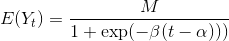

#### where M the maximal number of cases, 𝛼 the number of days at which the expected number of counts is half way the maximum,and 𝛽 > 0 the growth parameter. 
#### This however is just an approximation.

In [ ]:
import scipy.optimize as opt
from sklearn.metrics import mean_squared_log_error

def sigmoid(x, M, beta, alpha):
    return M / (1 + np.exp(-beta * (x - alpha)))

def train_sigmoid(data):
    if sum(data) == 0 or sum(data != 0) <= 3:
        return (2*data[-1], 0.25, 0)
    filtered_data = data[data > 0]#list(map(lambda x:int(x),list(data[data > 0])))
    try:        
        popt, pcov = opt.curve_fit(sigmoid, list(range(sum(data == 0), len(data))), 
                                   filtered_data, maxfev=10000, p0=[171550, 0.05, 120])
        print(popt, pcov)
        return popt
    except Exception as e:
        print(e)
        return (2*data[-1], 0.25, 0) 

In [ ]:
national_df = statewise_daily_stats_pivot.groupby("Date", as_index=False).agg({"Hospitalized":"sum"}).rename({"Hospitalized":"ConfirmedCases"}, axis=1)
national_df = national_df.sort_values("Date")
national_df["CumulativeConfirmed"] = national_df['ConfirmedCases'].cumsum()
today = datetime.now().strftime("%Y-%m-%d")
national_df = national_df.query("Date < @today")

M, beta, alpha = train_sigmoid(national_df["CumulativeConfirmed"])
print(M, beta, alpha)
steps = 80
x = list(range(0, len(national_df) + steps))
max_index = national_df.index
max_date = national_df["Date"].max()
for i in range(steps):
    national_df.loc[national_df.index.max() + 1] = [np.datetime64(max_date + np.timedelta64(i+1, "D")), np.NaN, np.NaN]
national_df

national_df["Preds"] = np.NaN
national_df["Preds"] = national_df.apply(lambda x:np.clip(sigmoid(x.index+1, M, beta, alpha), 0, None).astype(int))

fig = go.Figure()

x = list(range(0, len(national_df) + steps))
national_df["Preds"] = national_df.apply(lambda x:np.clip(sigmoid(x.index, M, beta, alpha), 0, None).astype(int))

fig.add_trace(go.Scatter(
            x=national_df["Date"], y=national_df["Preds"],
            name=f'National Cumulative Cases Predictions',
            line=dict(color="Green", dash='dash')
        ))

fig.add_trace(go.Scatter(
            x=national_df["Date"], y=national_df["CumulativeConfirmed"],
            name=f'National Cumulative Cases Actual',
            line=dict(color="blue")
        ))
fig.update_layout(
        title="Total Cases in India Convergance", xaxis_title='Date', yaxis_title='Confirmed cases')
fig.add_trace(go.Scatter(x=[datetime.now()-timedelta(days=1), datetime.now()-timedelta(days=1)], y=[0, 1.1*M], name='Current Day', line=dict(dash='dot', color=('rgb(200, 200, 200)'))))
fig.update_layout(
    annotations=[
        dict(
            x=datetime.now()-timedelta(days=10),
            y=1.1*M,
            xref="x",
            yref="y",
            text="Actual",
            showarrow=False,
        ),
        dict(
            x=datetime.now()+timedelta(days=10),
            y=1.1*M,
            xref="x",
            yref="y",
            text="Predicted",
            showarrow=False,
        )
    ]
)
fig.show()

#### If the above graph is to be believed, the growth of new cases will start slowing down starting June last week, and the Maximum predicted cases will be around ~171K.[](http://)

In [ ]:
national_df = statewise_daily_stats_pivot.groupby("Date", as_index=False).agg({"Deceased":"sum"})
national_df = national_df.sort_values("Date")
national_df["CumulativeDeceased"] = national_df['Deceased'].cumsum()
today = datetime.now().strftime("%Y-%m-%d")
national_df = national_df.query("Date < @today")

M, beta, alpha = train_sigmoid(national_df["CumulativeDeceased"])
print(M, beta, alpha)
steps = 80
x = list(range(0, len(national_df) + steps))
max_index = national_df.index
max_date = national_df["Date"].max()
for i in range(steps):
    national_df.loc[national_df.index.max() + 1] = [np.datetime64(max_date + np.timedelta64(i+1, "D")), np.NaN, np.NaN]
national_df

national_df["Preds"] = np.NaN
national_df["Preds"] = national_df.apply(lambda x:np.clip(sigmoid(x.index+1, M, beta, alpha), 0, None).astype(int))

fig = go.Figure()

x = list(range(0, len(national_df) + steps))
national_df["Preds"] = national_df.apply(lambda x:np.clip(sigmoid(x.index, M, beta, alpha), 0, None).astype(int))

fig.add_trace(go.Scatter(
            x=national_df["Date"], y=national_df["Preds"],
            name=f'National Cumulative Deceased Predictions',
            line=dict(color="Green", dash='dash')
        ))

fig.add_trace(go.Scatter(
            x=national_df["Date"], y=national_df["CumulativeDeceased"],
            name=f'National Cumulative Deceased Actual',
            line=dict(color="blue")
        ))
fig.update_layout(
        title="Total Deaths in India Convergance", xaxis_title='Date', yaxis_title='Confirmed cases')
fig.add_trace(go.Scatter(x=[datetime.now()-timedelta(days=1), datetime.now()-timedelta(days=1)], y=[0, 1.1*M], name='Current Day', line=dict(dash='dot', color=('rgb(200, 200, 200)'))))
fig.update_layout(
    annotations=[
        dict(
            x=datetime.now()-timedelta(days=13),
            y=1.1*M,
            xref="x",
            yref="y",
            text="Actual",
            showarrow=False,
        ),
        dict(
            x=datetime.now()+timedelta(days=13),
            y=1.1*M,
            xref="x",
            yref="y",
            text="Predicted",
            showarrow=False,
        )
    ]
)
fig.show()

#### According to this graph, the growth of new deaths will start slowing down starting June beginning, and the Maximum predicted deaths will be around 4788.

# References

#### Below kernels were extremely inspiring for this analysis. Do upvote these as well.
* [COVID-19: current situation on May [Daily update]](https://www.kaggle.com/corochann/covid-19-current-situation-on-may-daily-update)
* [Sigmoid per country](https://www.kaggle.com/group16/sigmoid-per-country-no-leakage)
* [COVID-19 growth rates per country](https://www.kaggle.com/mikestubna/covid-19-growth-rates-per-country)


# Further Reading

#### Checkout the AnalyticsVidhya article where I take up similar data around covid for India, to perform Time-Series Analysis using Booting and Hyperparamter-optimization - [Tracking COVID-19 spread in India — Time-Series data modeling and clustering in Python](https://medium.com/analytics-vidhya/tracking-covid-19-spread-in-india-time-series-data-modeling-and-clustering-in-python-f3ca70eb4f2)